# Computer Vision

## Overview

* Lochkamera
* Farbraeume
* CCD/CMOS
* Weltkoordinaten
* Bayersfilter
* RGB / HSV
* Camshift
* Image moments
    * Ableitung
* Background Subtraction
    * Exponentieller Tiefpass
* Morphologische Operatoren
    * Strukturelemente
    * Erosion
    * Dilatation
    * Opening & Closing
* Sobel
* Canny Edge
    * Non-maximum suppression
* HOG
    * Invariant gegen scale und translation
* Hough Transformation
* Interest Points
* Taylor approximation
* Moravecs Corners
* Harris Corner Detection
    * Structure Tensor
* LoG und DoG
* Optical Flow
* Lucas-Kanade
* Shi-Tomasi
* SURF
* SIFT
* SVD
* Kameramatrizen
* Projektion


In [1]:
# do all the import stuff
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image
from skimage import feature
from scipy import signal, ndimage
import numpy as np
import math
import cv2
import math

# import my modules
import sys
sys.path.append('/home/julian/dev/computer_vision_ws2015/')

import juvis as jv

Smila = np.array(Image.open('smila.png').convert('L'))
Factor = 0.5
size = (int(Smila.shape[1] * Factor), int(Smila.shape[0] * Factor))
Smila = jv.imresize(Smila, size)

# Projection

## Camera matrix

$3\times 4$ matrix $C$ that describes the mapping of a pinhole camera from 3D points in the world to 2D points in an image (11 degrees of freedom).

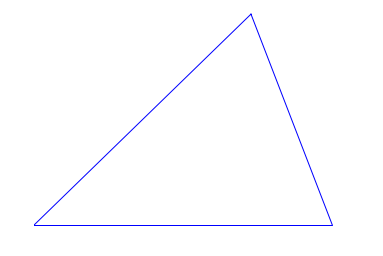

In [2]:
# Camera matrix

def generate_camera(f):
    """
    @param f: focal length
    """
    return np.array([
            [1,0,0,0],
            [0,1,0,0],
            [0,0,1.0/f,0]])

def homo(V):
    R = np.ones((V.shape[0]+1, 1))
    for i in range(0, V.shape[0]):
        R[i,0] = V[i,0]
    return R

def de_homo(H):
    last = H.shape[0] - 1
    if H[last,0] == 0:
        return np.zeros((last, 1))
    else:
        H = H/H[last,0]
        r = np.zeros((last, 1))
        for i in range(0, last):
            r[i,0] = H[i,0]
        return r

C = generate_camera(1)

v1 = homo(np.array([[10],[10],[11]]))
v2 = homo(np.array([[0],[10],[12]]))
v3 = homo(np.array([[15],[10],[12]]))

p1 = de_homo(np.dot(C, v1))
p2 = de_homo(np.dot(C, v2))
p3 = de_homo(np.dot(C, v3))

xp = [p1[0], p2[0], p3[0], p1[0]]
yp = [p1[1], p2[1], p3[1], p1[1]]

plt.plot(xp, yp)
plt.axis('off')
plt.show()

In [3]:
# Show value of Smila
I = np.array(Image.open('smila.png').convert('RGB'))

import colorsys

H = np.zeros((I.shape[0], I.shape[1]))
S = np.zeros((I.shape[0], I.shape[1]))
V = np.zeros((I.shape[0], I.shape[1]))
for x in range(0, I.shape[1]):
    for y in range(0, I.shape[0]):
        h, s, v = colorsys.rgb_to_hsv(I[y,x,0], I[y,x,1], I[y,x,2])
        H[y,x] = h
        S[y,x] = s
        V[y,x] = v


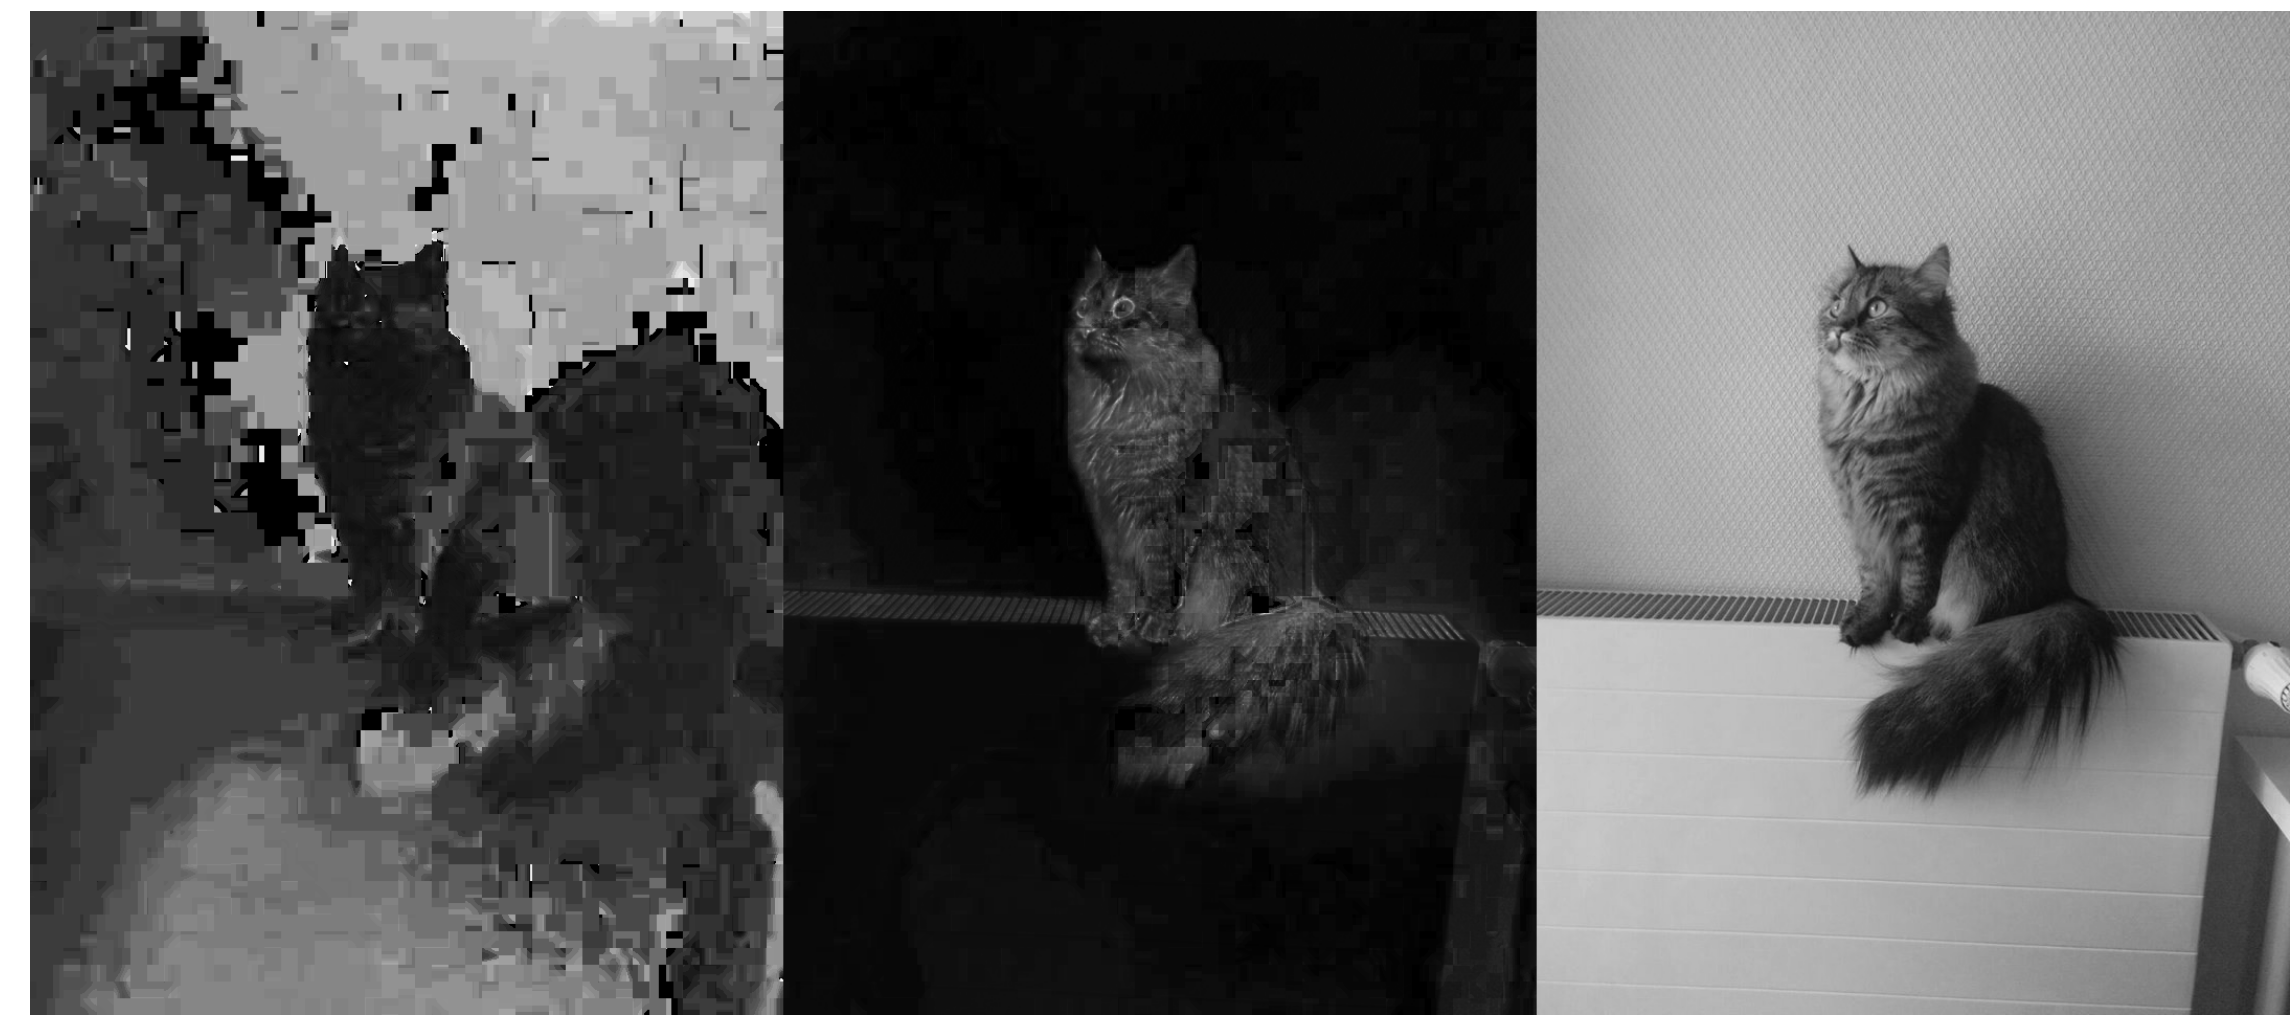

In [4]:
# paint
Hi = H.copy()
Si = S.copy()
Vi = V.copy()

Hi = jv.translate(Hi, 0, 1, 0, 255)
Si = jv.translate(Si, 0, 1, 0, 255)

jv.plot_mats([Hi, Si, Vi], cols=3, size=32)

## Difference of Gaussian

feature enhancement algorithm

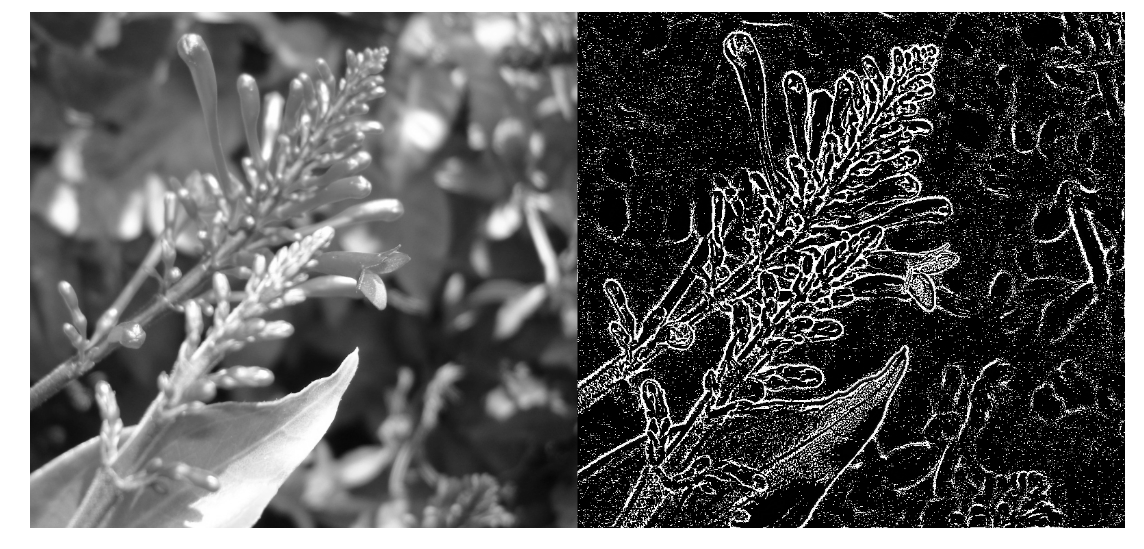

In [39]:
# DoG (image from wikipedia)
I = Smila.copy()

A = ndimage.filters.gaussian_filter(I, 0.9)
B = ndimage.filters.gaussian_filter(I, 4)

C = B - A

I = np.array(Image.open('flow_wiki.jpg').convert('L'))

A = ndimage.filters.gaussian_filter(I, 0.2)
B = ndimage.filters.gaussian_filter(I, 1)
C = A - B

jv.plot_mats([I, C], cols=2)

## Canny edge
* Apply Gaussian filter to remove noise
* Find intensity gradients of the image
* Apply non-maximum suppression to get rid of sporious response to edge detection
* Apply double threshold todetermine potential edges
* Track edge by hysteresis: Finalize detection of edges by suppressing all the other edges that are weak and not connected to strong edges

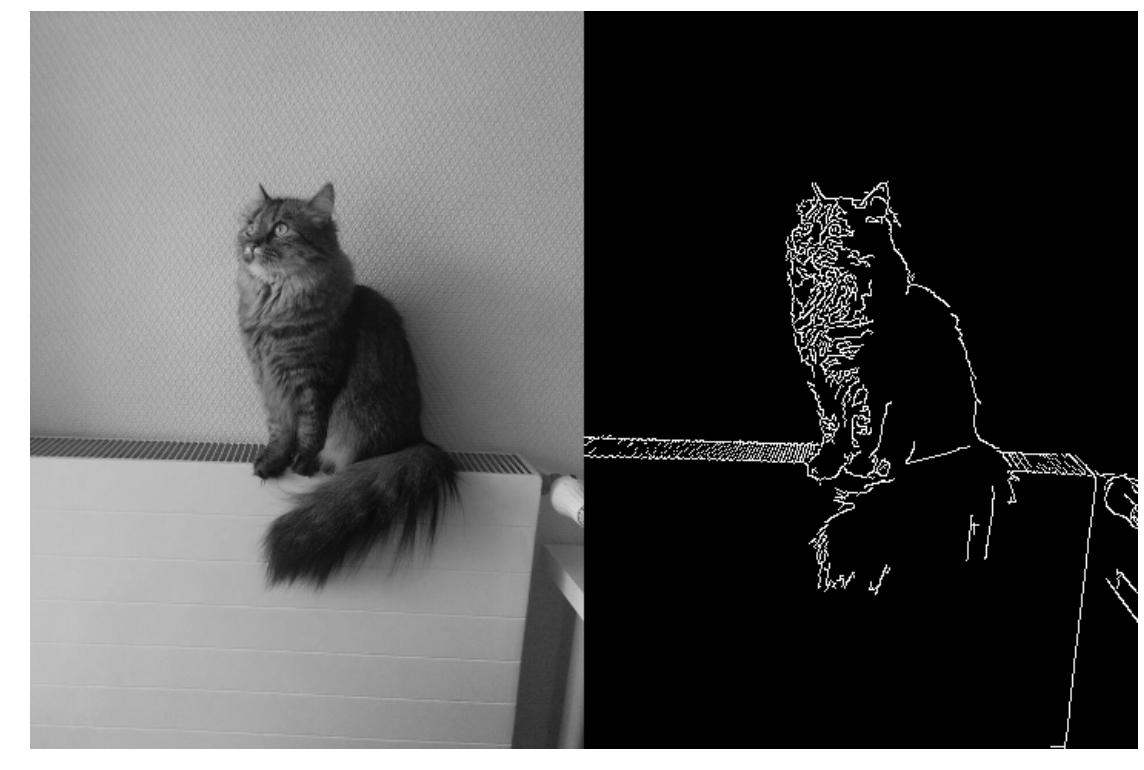

In [5]:
I = Smila.copy()
E = cv2.Canny(I, 70, 200)
jv.plot_mats([I, E], cols=2, size=16)

## Hough transform

* Feature extraction technique
* Find imperfect instances of objects within class of shapes by a voting procedure

Hough transforms between the Cartesian space and a parameter space in which straight lines (or other boundary formulations) can be defined.

The main advantage of Hough transform is that it tolerates gaps in feature boundary descriptions and is relativly unaffected by image noise.

### Hesse normal form
Representation for a line
* unit normal vector $\vec{n_0}$ to represent the direction of the line
* $d \geq 0$ to define distance to to the origin

$$ \vec{x} \cdot \vec{n_0} = d $$
$$ \rho = x\cos{\theta} + \sin{\theta}$$

### Hough Space

![Cartesian space to Hough space](hough_line.png)

* One line in Cartesian space is mapped to a point in Hough-Space

200
[[41.58233816355187, 195.62952014676114]]


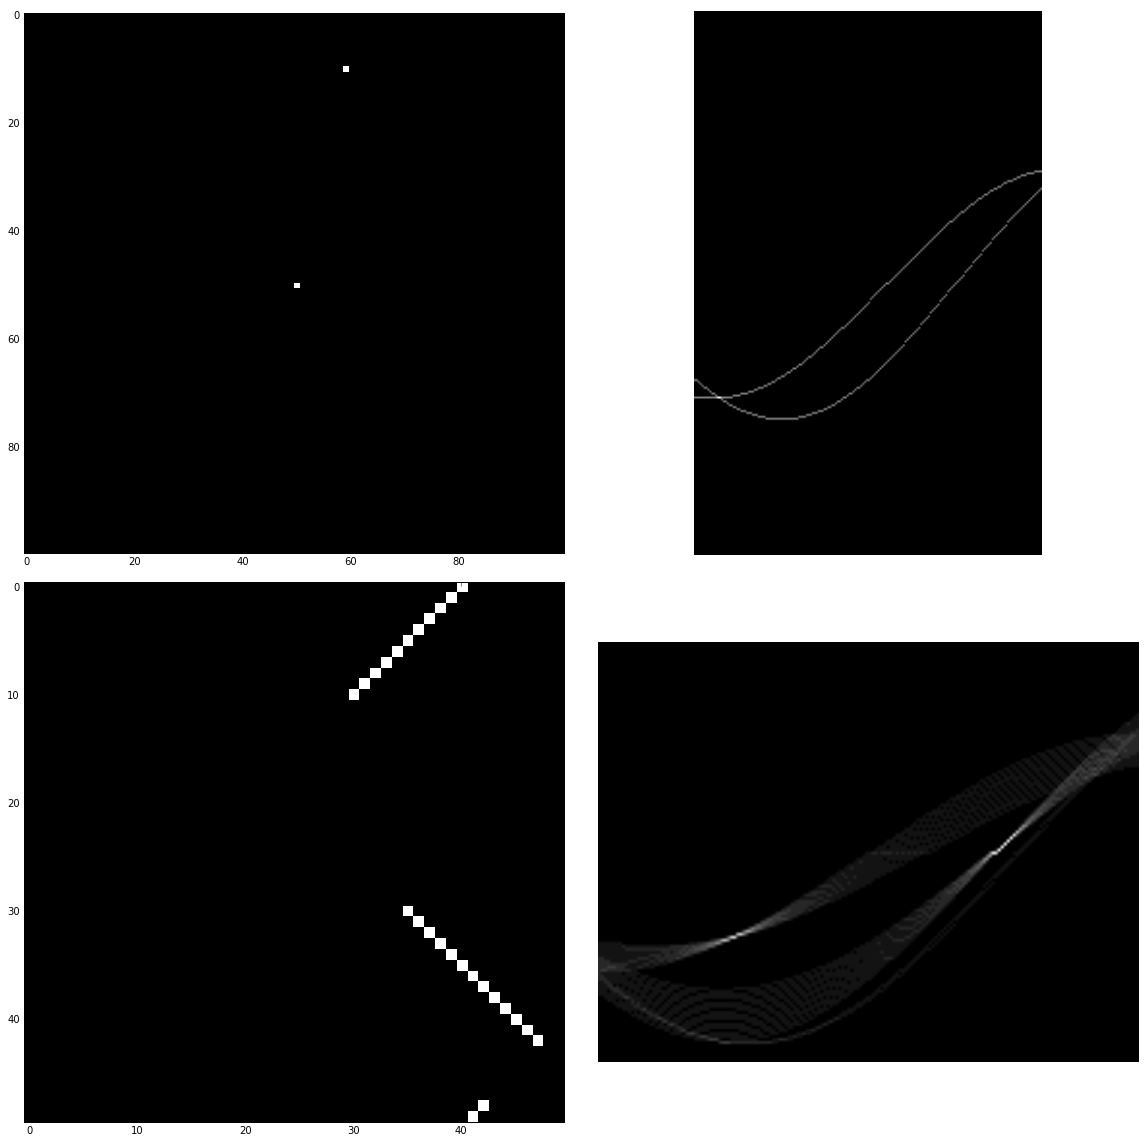

In [6]:
# hough

I = np.zeros((100,100))
I[50,50] = 1
I[10, 59] = 1

def transform_hough_space_line(I):
    deg = 180
    mdist = int(math.sqrt(I.shape[0]**2 + I.shape[1]**2))
    H = np.zeros((2*mdist, deg))
    Extr = jv.extract_points(I)
    for [y,x] in Extr:
        for Phi in range(0, deg):
            #rad = math.radians(Phi-int(deg/2))
            rad = math.radians(Phi)
            p = int(x * math.cos(rad) + y * math.sin(rad))
            p += mdist
            H[p,Phi] = H[p,Phi] + 1
    return H

def dehough_line(H):
    """
    de-houghs a hough space using a very primitive method..
    @params H: Hough space
    """
    results = []
    deg = H.shape[1]
    
    lower_bound = np.max(H) * 0.5  # everything below is just a point..
    lowest_dist = 5
    
    R = (H > lower_bound) * 1
    
    candidates = jv.extract_points(R)
    propective_lines = []
    
    # broken!
    for i in range(0, len(candidates), 2):
        for j in range(1, len(candidates), 2):
            A = candidates[i]
            B = candidates[j]
            dist = math.sqrt((A[0]-B[0])**2 + (A[1]-B[1])**2)
            propective_lines.append(A)
            if dist > lowest_dist:
                propective_lines.append(B)
    
    for [p, Rho] in propective_lines:
        #rad = math.radians(Rho-int(deg/2))
        print(p)
        rad = math.radians(Rho)
        x = p * math.cos(rad)
        y = p * math.sin(rad)
        results.append([y,x])
    
    return results

H = transform_hough_space_line(I)

R = dehough_line(H)
print(R)

# Plot the stuff
f, [[ax, ay], [ax2, ay2]] = plt.subplots(ncols=2, nrows=2)
f.set_size_inches(16,16)
ax.imshow(I, cmap=plt.get_cmap('gray'), interpolation="nearest")

#ax.plot([R[0][1], R[0][0]])

ay.imshow(H, cmap=plt.get_cmap('gray'))
ay.axis('off')

I = np.zeros((50,50))
for i in range(30, 43):
    I[i,i+5] = 1
    I[40-i,i] = 1
    
H = transform_hough_space_line(I)
ax2.imshow(I, cmap=plt.get_cmap('gray'), interpolation="nearest")
ay2.imshow(H, cmap=plt.get_cmap('gray'))


ay2.axis('off')
plt.tight_layout()
plt.show()

In general, the number of dimensions af the accumulator corresponds to the number of unknown parameteres in the Hough transform problem.

Some examples:
* Ellipse: 5-dimensional, coordinate of the center, length of major and minor axis, and angle


#### Limitations
A high number of votes must fall in the right bin, so that background-noise cannot influence the decission meaning that bins must not be too small or else some votes will fall in neighboring bins which reduces the visibility of the main bin.

Another issue arrises with big parameter spaces as the memory consumption can rise a lot.

Efficiency of the algorithm depends on the input data and how well the edges were detected.


## generalized Hough transform

Priciple of template matching, when there is no simple analytic equation that could describe the boundary. Instead of using an equation we use a look-up table to define the relationship between boundary positions and orientations and the Hough parameters.